In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import xmltodict
import requests
import json

import warnings
warnings.filterwarnings('ignore')

In [2]:
def read_rn(fname):
    """
    Read Rainvalue data
    fname(str)
    """
    try:
        g_df = pd.read_csv(fname,encoding='cp949')
    except e:
        g_df = pd.read_csv(fname,encoding='utf-8')
    g_df = g_df[:-1]
    g_df['일시'] = pd.to_datetime(g_df['일시'])
    
    return g_df

In [3]:
def make_datedf(startDt,endDt):
    """
    startDt(str) : 'yyyymmdd'
    endDt(str) : 'yyyymmdd'
    """
    # Make dates dataframe
    dates = pd.date_range(startDt,endDt,freq='T',inclusive='neither').to_list()#.strftime('%Y-%m-%d %H:%M').to_list()
    df = pd.DataFrame(columns=['일시'])
    df['일시'] = dates
    return df

In [4]:
def merge_df(date_df, data_df):
    """
    Merge dataframe (date dataframe, data datafrmae)
    """
    g_data = pd.merge(date_df,data_df,on='일시',how='left')
    g_data = g_data[['일시','1분 강수량(mm)', '강수유무(유무)']]
    g_data.rename(columns={'일시':'dates','1분 강수량(mm)':'rn','강수유무(유무)':'flag'},inplace=True)

    return g_data

In [5]:
def read_lvdata(fname):
    """
    Read levels data (Road, Sewer)
    fname(str)
    """
    try:
        levels = pd.read_csv(fname)
    except e:
        levels = pd.read_csv(fname, encoding='cp949')
    levels.rename(columns={'crtr_tm':'dates'}, inplace=True)
    levels['dates'] = pd.to_datetime(levels['dates'])
    del levels['data_clct_se']

    return levels

In [6]:
def load_riverlv(startDt, endDt, apiKey, stnCode):
    """
    Load river level data (API)
    startDt(str) : 'yyyymmdd'
    endDt(str) : 'yyyymmdd'
    apiKey(str)
    stnCode(str)
    """
    all_dates = pd.date_range(start=startDt, end=endDt, freq='10T',inclusive='neither')#.strftime('%Y%m%d%H%M').to_list()
    
    monthly_lists = []
    
    for month in range(all_dates[0].month, all_dates[-1].month+1):
        monthly_dates = all_dates[all_dates.month == month]
        monthly_dates = monthly_dates.strftime('%Y%m%d%H%M')
        
        monthly_lists.append(list(monthly_dates))

    apiKey = apiKey
    code = stnCode
    wl_df = pd.DataFrame(columns=['ymdhm','wlobscd','wl','fw'])
    
    # Request water level data
    for m in monthly_lists:
        url = f'http://api.hrfco.go.kr/{apiKey}/waterlevel/list/10M/{code}/{m[0]}/{m[-1]}.xml'
        res = requests.get(url)
        xmlToDict = xmltodict.parse(res.text) # return collections.OrderedDict
        df_dict = json.loads(json.dumps(xmlToDict)) # return dict
        tmp_df= df_dict['entities']['content']['Waterlevel']
        tmp_df = pd.DataFrame(tmp_df)
    
        wl_df = pd.concat([wl_df,tmp_df])

    wl_df.sort_values(by='ymdhm',inplace=True,ignore_index=True)
    wl_df['ymdhm'] = pd.to_datetime(wl_df['ymdhm'])
    wl_df['ymdhm'] = wl_df['ymdhm'].astype('str')
    wl_df.rename(columns={'ymdhm':'dates'},inplace=True)

    wl_df = wl_df[['dates','wl']]

    return wl_df

In [7]:
region = {0 : 'gwangjoo', 1 : 'changwon', 2 : 'pohang'}
wl_stn = {0 : '5002690', 1 : '2020675', 2 : ''}
aws = {0 : 'gwangsan', 1 : 'masan'}
fname = {0 : '2920010001045020', 1 : '4812110001018020', 2 : ''}
# Region code select
r_cd = 0

apiKey = 'B9344389-836E-43B7-9AF5-A2400B1A3065'
startDt = '20240301'
endDt = '20241201'

rn_df = read_rn(f'../dataset/AWS_{aws[r_cd]}.csv')
date_df = make_datedf(startDt,endDt)
rn_data = merge_df(date_df, rn_df)
levels = read_lvdata(f'../dataset/smart_rain/{region[r_cd]}/processed_{region[r_cd]}_{fname[r_cd]}.csv')

dataset = pd.merge(rn_data,levels,on='dates',how='left')

In [8]:
wl_df = load_riverlv(startDt,endDt,  apiKey, wl_stn[r_cd])
dataset['dates'] = dataset['dates'].astype('str')
data = pd.merge(dataset,wl_df,on='dates',how='left')

In [9]:
data.reset_index(inplace=True,drop=True)
data['rn'] = data['rn'].astype(float) # Unit : mm
data['wl'] = data['wl'].astype(float) # Unit : m
data['vl'] = data['vl'].astype(float) # Unit : mm

In [10]:
# Fill the first value to interpolate
if np.isnan(data['wl'][0]):
    data['wl'][0] = data['wl'].dropna().mean()

In [11]:
print(f'Rainfall min, max, mean : {data['rn'].min()}, {data['rn'].max()}, {np.round(data['rn'].mean(),5)}')
print(f'River level min, max, mean : {data['wl'].min()}, {data['wl'].max()}, {np.round(data['wl'].mean(),5)}')
print(f'Sewer level min, max, mean : {data['vl'].min()}, {data['vl'].max()}, {np.round(data['vl'].mean(),5)}')

Rainfall min, max, mean : 0.0, 3.0, 0.00317
River level min, max, mean : 1.45, 3.32, 1.75778
Sewer level min, max, mean : 0.0, 100.0, 16.07972


## Make test set

In [12]:
data['wl'] = data['wl'].interpolate()
data['rn'] = data['rn'].interpolate()

## Make train set

In [13]:
# Replace the zero value to None value for doing the interpolation
data['vl'][data['vl']<0]=0
data['vl'] = data['vl'].replace(0., np.nan)

In [14]:
data['vl'] = data['vl'].interpolate()
data['wl'] = data['wl'].interpolate()
data['rn'] = data['rn'].interpolate()

## Correlation analysis

<Axes: >

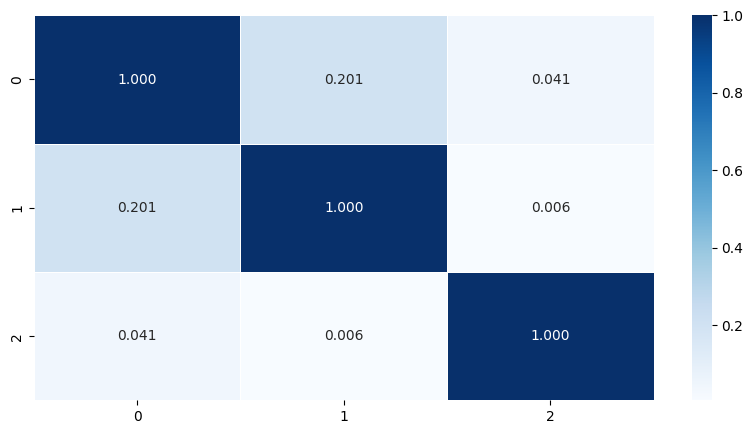

In [49]:
import seaborn as sns   
import matplotlib.pyplot as plt
cor_df = data[['vl','rn','wl']]
cor_df.rename(columns={'vl' : '관로수위', 'wl' : '하천 수위', 'rn' : '강우량'})

df_cor = cor_df.corr().values
plt.figure(figsize=(10,5))
sns.heatmap(data = df_cor, annot=True, fmt = '.3f', linewidths=.5, cmap='Blues')
# plt.savefig('df_cor.png')

In [51]:
cor_df.corr()

,vl,rn,wl
vl,1.000000,0.200656,0.040627
rn,0.200656,1.000000,0.005516
wl,0.040627,0.005516,1.000000


In [23]:
data.to_csv('../dataset/smart_rain/trainset/sewer/org_2920010001045020.csv',encoding='cp949',index=False)

## Plot the dataset

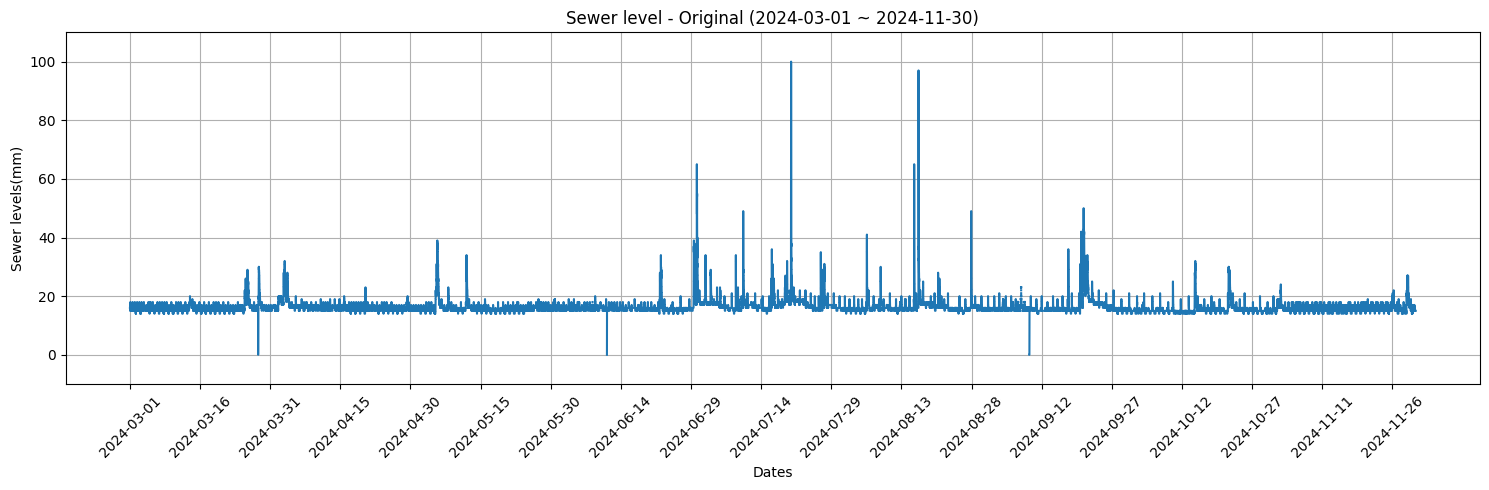

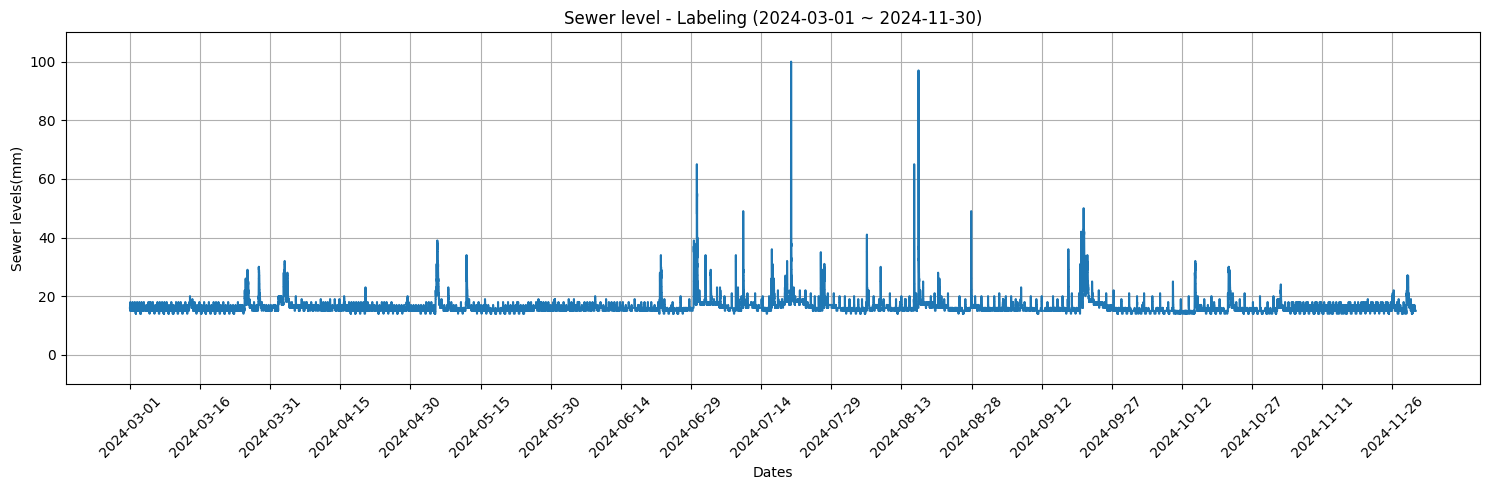

In [15]:
# Plot the dataset

time_str_list = data['dates'].to_list()
interval = 21600  # 15일 = 1440분 * 15

tick_positions = list(range(0, len(time_str_list), interval))
tick_labels = [time_str_list[i][:10] for i in tick_positions]  # 'YYYY-MM-DD' 형식만 추출

# 예시 y값 (동일 길이)
y_values = list(range(len(time_str_list)))

# 그래프 그리기
plt.figure(figsize=(15, 5))
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)
plt.title('Sewer level - Original (2024-03-01 ~ 2024-11-30)')
plt.xlabel('Dates')
plt.ylabel('Sewer levels(mm)')
plt.ylim(dataset['vl'].min()-10, dataset['vl'].max()+10) 
plt.plot(time_str_list, dataset['vl'])
plt.grid(True)

# x축 라벨 적용 (보름마다만)

plt.tight_layout()
plt.savefig(f'./imgs/org_sewer_{region[r_cd]}_{fname[r_cd]}.png')
plt.show()


# 그래프 그리기
plt.figure(figsize=(15, 5))
plt.plot(time_str_list, data['vl'])

# x축 라벨 적용 (보름마다만)
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)

plt.title('Sewer level - Labeling (2024-03-01 ~ 2024-11-30)')
plt.xlabel('Dates')
plt.ylabel('Sewer levels(mm)')
plt.ylim(dataset['vl'].min()-10, dataset['vl'].max()+10)
plt.grid(True)
plt.tight_layout()
plt.savefig(f'./imgs/inter_sewer_{region[r_cd]}_{fname[r_cd]}.png')
plt.show()

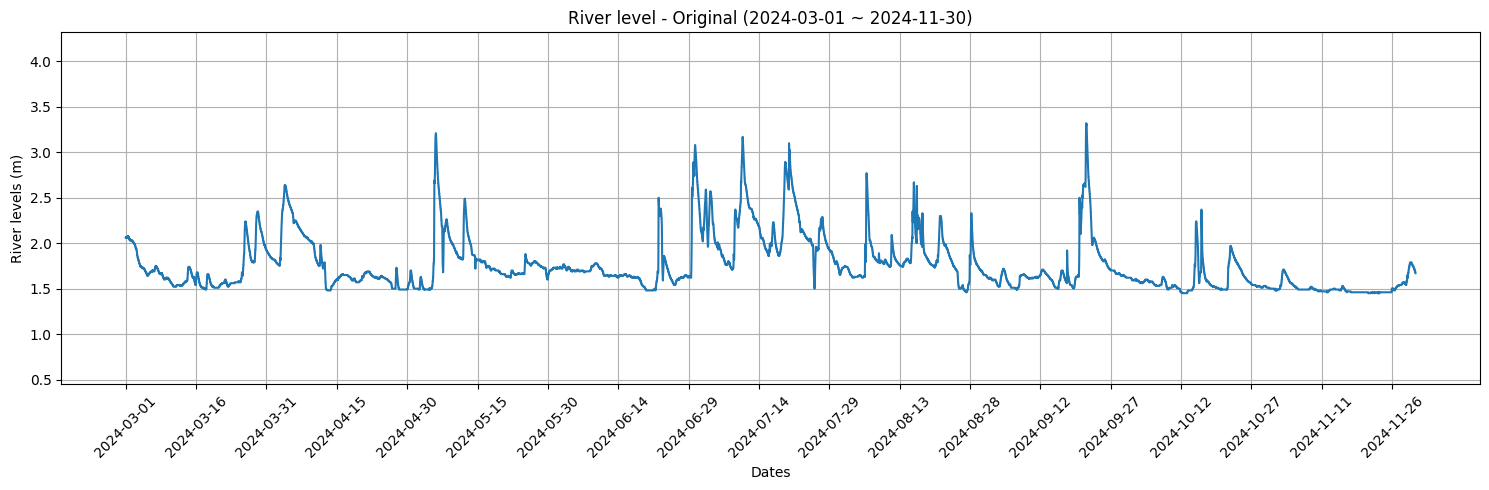

In [ ]:
# Plot the dataset

# 날짜 순으로 정렬
wl_df = wl_df.sort_values('dates')

# 정렬된 상태에서 다시 추출
time_str_list = wl_df['dates'].to_list()
wl_values = wl_df['wl'].astype(float).to_list()

# x축 틱 라벨 설정
interval = 2160
tick_positions = list(range(0, len(time_str_list), interval))
tick_labels = [time_str_list[i][:10] for i in tick_positions]

# 플로팅
plt.figure(figsize=(15, 5))
plt.plot(time_str_list, wl_values)
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)
plt.title('River level - Original (2024-03-01 ~ 2024-11-30)')
plt.xlabel('Dates')
plt.ylabel('River levels (m)')
plt.ylim(min(wl_values)-1, max(wl_values)+1)
plt.grid(True)
plt.tight_layout()
plt.savefig(f'./imgs/org_river_{region[r_cd]}_{fname[r_cd]}.png')
plt.show()

time_str_list = data['dates'].to_list()
interval = 21600  # 15일 = 1440분 * 15

tick_positions = list(range(0, len(time_str_list), interval))
tick_labels = [time_str_list[i][:10] for i in tick_positions]  # 'YYYY-MM-DD' 형식만 추출

# 예시 y값 (동일 길이)
y_values = list(range(len(time_str_list)))

# 그래프 그리기
plt.figure(figsize=(15, 5))
plt.grid(True)
plt.plot(time_str_list, data['wl'])

# x축 라벨 적용 (보름마다만)
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)

plt.title('River level - Labeling (2024-03-01 ~ 2024-11-30)')
plt.xlabel('Dates')
plt.ylabel('River levels(m)')
plt.ylim((wl_df['wl'].astype('float')).min()-1, (wl_df['wl'].astype('float')).max()+1) 

plt.tight_layout()
plt.savefig(f'./imgs/inter_river_{region[r_cd]}_{fname[r_cd]}.png')
plt.show()

In [ ]:
# Plot the dataset

time_str_list = data['dates'].to_list()
interval = 21600  # 15일 = 1440분 * 15

tick_positions = list(range(0, len(time_str_list), interval))
tick_labels = [time_str_list[i][:10] for i in tick_positions]  # 'YYYY-MM-DD' 형식만 추출

# 예시 y값 (동일 길이)
y_values = list(range(len(time_str_list)))

# 그래프 그리기
plt.figure(figsize=(15, 5))
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)
plt.title('Rain value - Original (2024-03-01 ~ 2024-11-30)')
plt.xlabel('Dates')
plt.ylabel('Rain value(mm)')
plt.ylim(rn_data['rn'].min()-1, rn_data['rn'].max()+1) 
plt.plot(time_str_list, rn_data['rn'])
plt.grid(True)

# x축 라벨 적용 (보름마다만)

plt.tight_layout()
plt.savefig(f'./imgs/org_rain_{region[r_cd]}_{fname[r_cd]}.png')
plt.show()


# 그래프 그리기
plt.figure(figsize=(15, 5))
plt.plot(time_str_list, data['rn'])

# x축 라벨 적용 (보름마다만)
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)

plt.title('Rain level - Labeling (2024-03-01 ~ 2024-11-30)')
plt.xlabel('Dates')
plt.ylabel('Rain levels(mm)')
plt.ylim(rn_data['rn'].min()-1, rn_data['rn'].max()+1)
plt.grid(True)
plt.tight_layout()
plt.savefig(f'./imgs/inter_rain_{region[r_cd]}_{fname[r_cd]}.png')
plt.show()

In [17]:
data.to_csv(f'../dataset/smart_rain/trainset/sewer/{fname[r_cd]}.csv',index=False, encoding='cp949')